# 1D-CAE Trainer

## Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

from utils import *
from cnn import *

In [2]:
!nvidia-smi -L

device = get_default_device()

GPU 0: NVIDIA GeForce RTX 3080 Ti (UUID: GPU-f3c6115e-46cd-6ccc-eedb-5f06a170552d)


## Data Pre-Processing

### Read scada

In [3]:
freq = '5min' # 5min

In [4]:
zone_name = 'zone7'
save_path = 'model_savings'
check_and_create_directory(save_path)

Directory 'model_savings' not exists，already created.


In [5]:
data_path = './data/l-town-data/2019_SCADA_Pressures.csv'

In [6]:
sensors_list = {

'zone1' : ['n1','n4','n31'],

'zone2' : ['n410','n429'],

'zone3' : ['n342','n636','n644'],

'zone4' : ['n296','n679','n722','n740'],

'zone5' : ['n288','n726','n752','n769'],

'zone6' : ['n215','n229'],

'zone7' : ['n163','n188','n613'],

'zone8' : ['n332','n495','n506','n549'],

'zone9' : ['n105','n114','n469', 'n516'],

'zone10' : ['n54','n415','n458', 'n519']
    
}

In [7]:
zone_sensors = sensors_list[zone_name]

In [8]:
#Read data
scada = pd.read_csv(data_path, sep=';', decimal=',', index_col='Timestamp')#, nrows=1000)
scada.index = pd.date_range(start=scada.index[0], periods=len(scada), freq=freq)
scada = scada.loc[:, zone_sensors]

### Data proprocess

In [9]:
start_time = pd.Timestamp('2019-01-01 00:00')
split_time = pd.Timestamp('2019-01-15 00:00')

In [10]:
train = scada[start_time:split_time]

In [11]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(train)
train = pd.DataFrame(x_scaled)

### Sliding window

In [12]:
window_size=288
step = 1

In [13]:
windows_train=train.values[np.arange(window_size)[None, :] + np.arange(train.shape[0]-window_size)[::step, None]]
windows_train = windows_train.swapaxes(1,2)
windows_train.shape

(3745, 3, 288)

## Training

In [14]:
import torch.utils.data as data_utils

BATCH_SIZE = 144
N_EPOCHS = 100

feature_size=windows_train.shape[1]
seq_len=windows_train.shape[2]

windows_train_train = windows_train[:int(np.floor(.8 *  windows_train.shape[0]))]
windows_train_val = windows_train[int(np.floor(.8 *  windows_train.shape[0])):int(np.floor(windows_train.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_train_train).float()
) , batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_train_val).float()
) , batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

model = CNN(feature_size, seq_len)
model = to_device(model,device)

In [15]:
history = training(N_EPOCHS,model,train_loader,val_loader, f'./{save_path}/{zone_name}.pth')

Epoch [1], trn_loss: 0.1693, val_loss: 0.1534
Epoch [2], trn_loss: 0.1062, val_loss: 0.1163
Epoch [3], trn_loss: 0.0876, val_loss: 0.0882
Epoch [4], trn_loss: 0.0735, val_loss: 0.0702
Epoch [5], trn_loss: 0.0636, val_loss: 0.0586
Epoch [6], trn_loss: 0.0573, val_loss: 0.0527
Epoch [7], trn_loss: 0.0517, val_loss: 0.0475
Epoch [8], trn_loss: 0.0473, val_loss: 0.0438
Epoch [9], trn_loss: 0.0435, val_loss: 0.0403
Epoch [10], trn_loss: 0.0408, val_loss: 0.0380
Epoch [11], trn_loss: 0.0388, val_loss: 0.0360
Epoch [12], trn_loss: 0.0373, val_loss: 0.0346
Epoch [13], trn_loss: 0.0361, val_loss: 0.0337
Epoch [14], trn_loss: 0.0352, val_loss: 0.0325
Epoch [15], trn_loss: 0.0341, val_loss: 0.0315
Epoch [16], trn_loss: 0.0334, val_loss: 0.0307
Epoch [17], trn_loss: 0.0326, val_loss: 0.0300
Epoch [18], trn_loss: 0.0318, val_loss: 0.0290
Epoch [19], trn_loss: 0.0309, val_loss: 0.0285
Epoch [20], trn_loss: 0.0301, val_loss: 0.0276
Epoch [21], trn_loss: 0.0294, val_loss: 0.0269
Epoch [22], trn_loss: 

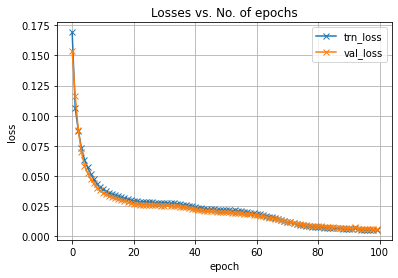

In [16]:
plot_history_cnn(history, zone_name)